In [363]:
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import numpy as np

In [364]:
# from https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-october-2022

prices = pd.read_csv('data/Average-prices-2022-10.csv', parse_dates=['Date'])
prices = prices[prices['Date'] >= dt.datetime(1995, 1, 1)].reset_index()

In [365]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135730 entries, 0 to 135729
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             135730 non-null  int64         
 1   Date              135730 non-null  datetime64[ns]
 2   Region_Name       135730 non-null  object        
 3   Area_Code         135730 non-null  object        
 4   Average_Price     135730 non-null  float64       
 5   Monthly_Change    135288 non-null  float64       
 6   Annual_Change     130846 non-null  float64       
 7   Average_Price_SA  4674 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 8.3+ MB


In [366]:
all_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales')].copy()

In [367]:
wales_avg = prices[prices['Region_Name'] == 'Wales']
newport = prices[prices['Region_Name'] == 'Newport']
rest_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales') & (prices['Region_Name'] != 'Newport')]

In [368]:
# bridges returned to public ownership in 01-2018, toll removal on 12-2018
treatment_date = dt.date(2018, 1, 1)

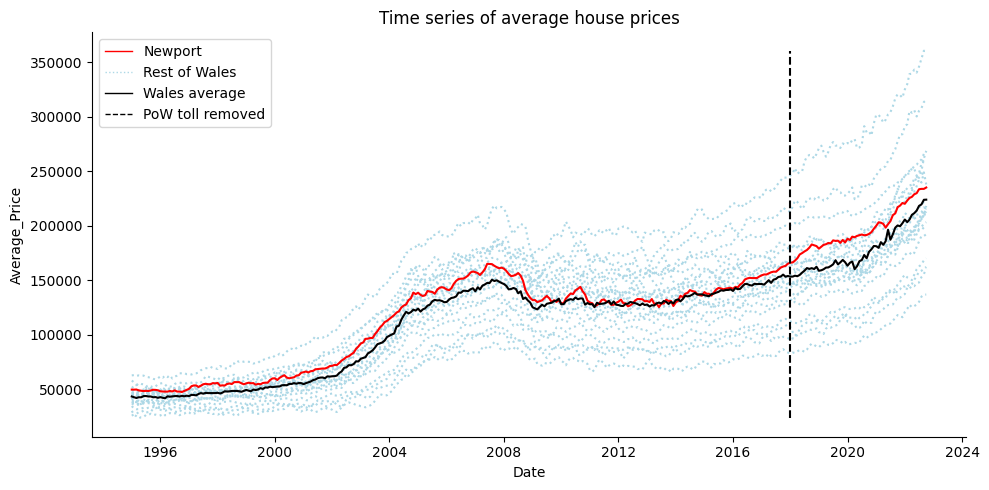

In [369]:
fig, ax = plt.subplots(figsize=(10, 5))

palette = sns.color_palette(['lightblue'], len(rest_wales.Region_Name.unique()))

ax = sns.lineplot(data=rest_wales, x='Date', y='Average_Price', hue='Region_Name', legend=False, palette=palette, linestyle=':')
ax = sns.lineplot(data=newport, x='Date', y='Average_Price', color='red')
ax = sns.lineplot(data=wales_avg, x='Date', y='Average_Price', color='black')
plt.vlines(treatment_date, ymin=min(all_wales['Average_Price']), ymax=max(all_wales['Average_Price']),
           linestyles='dashed', colors='black', label='PoW toll removed')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', linestyle=':', lw=1),
                Line2D([0], [0], color='black', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'Wales average', 'PoW toll removed'])
sns.despine()
plt.title('Time series of average house prices')
plt.tight_layout()
plt.savefig('output/time_series.png')
plt.show()

# Diff-in-diff

In [370]:
some_las = prices[(prices['Region_Name'] == 'Newport') | 
                  (prices['Region_Name'] == 'Wrexham')]

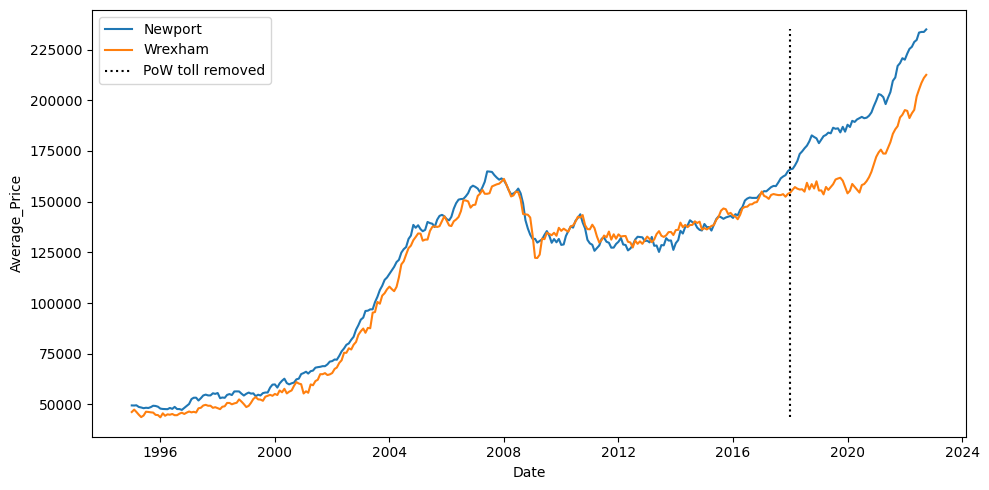

In [371]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=some_las, x='Date', y='Average_Price', hue='Region_Name')
plt.vlines(treatment_date, ymin=min(some_las['Average_Price']), ymax=max(some_las['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.legend()
plt.tight_layout()

plt.show()

In [372]:
some_las_pvt = some_las.pivot(index='Date', columns='Region_Name', values='Average_Price').reset_index()
some_las_pvt['ratio'] = some_las_pvt['Newport'] / some_las_pvt['Wrexham']

In [373]:
some_las_pvt

Region_Name,Date,Newport,Wrexham,ratio
0,1995-01-01,49472.32324,46228.36134,1.070173
1,1995-02-01,49430.55412,47401.20659,1.042812
2,1995-03-01,49545.96771,46263.41484,1.070954
3,1995-04-01,48717.06324,44885.56449,1.085361
4,1995-05-01,48459.02872,43715.76930,1.108502
...,...,...,...,...
329,2022-06-01,229775.77922,201900.01985,1.138067
330,2022-07-01,233401.23142,205323.66729,1.136748
331,2022-08-01,233727.47394,208569.72207,1.120620
332,2022-09-01,233718.62567,211023.63130,1.107547


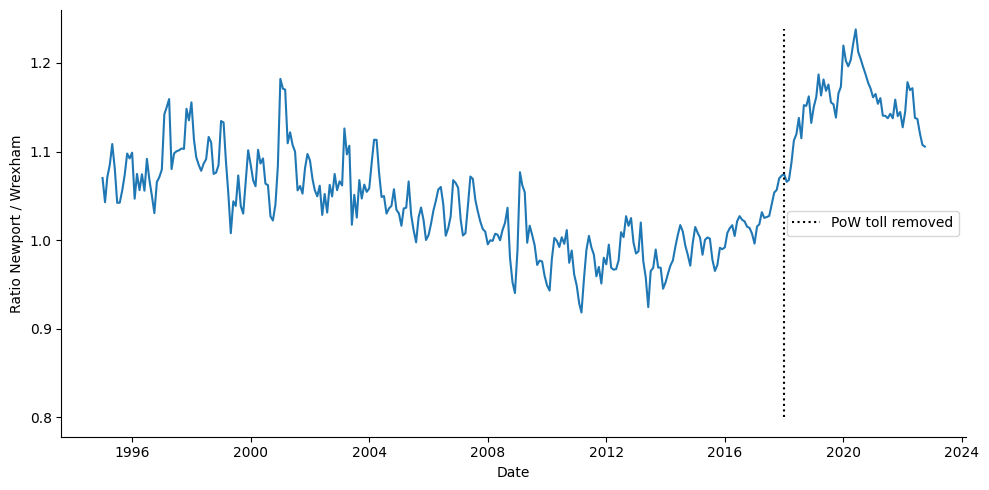

In [374]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=some_las_pvt, x='Date', y='ratio')
plt.vlines(treatment_date, ymin=0.8, ymax=max(some_las_pvt['ratio']),
           linestyles=':', colors='black', label='PoW toll removed')
# plt.ylim(0.5, 1.5)
plt.ylabel('Ratio Newport / Wrexham')
plt.legend(loc='center right')
plt.tight_layout()
sns.despine()
plt.show()

In [375]:
np_2016 = int(some_las[(some_las['Date'] == '01-01-2016') & (some_las['Region_Name'] == 'Newport')]['Average_Price'])
np_2020 = int(some_las[(some_las['Date'] == '01-01-2020') & (some_las['Region_Name'] == 'Newport')]['Average_Price'])

ca_2016 = int(some_las[(some_las['Date'] == '01-01-2016') & (some_las['Region_Name'] == 'Wrexham')]['Average_Price'])
ca_2020 = int(some_las[(some_las['Date'] == '01-01-2020') & (some_las['Region_Name'] == 'Wrexham')]['Average_Price'])

In [376]:
diff_in_diff = (np_2020 - np_2016) - (ca_2020 - ca_2016)
diff_in_diff

35013

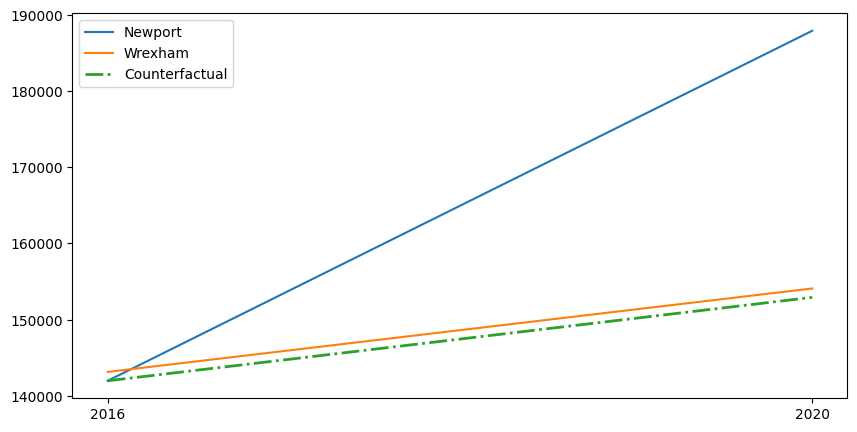

In [377]:
plt.figure(figsize=(10,5))
plt.plot(['2016', '2020'], [np_2016, np_2020], label='Newport')
plt.plot(['2016', '2020'], [ca_2016, ca_2020], label='Wrexham')

plt.plot(['2016', '2020'], [np_2016, np_2016+(ca_2020-ca_2016)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()

plt.show()

# Synthetic control

In [378]:
rest_wales = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales') & (prices['Region_Name'] != 'Newport')]
rest_wales_avg = rest_wales.groupby(by='Date')['Average_Price'].mean().reset_index()
rest_wales_avg['Region_Name'] = 'Rest of Wales'

newport = prices[prices['Region_Name'] == 'Newport'][['Date', 'Average_Price', 'Region_Name']]

In [379]:
data = pd.concat([newport, rest_wales_avg])

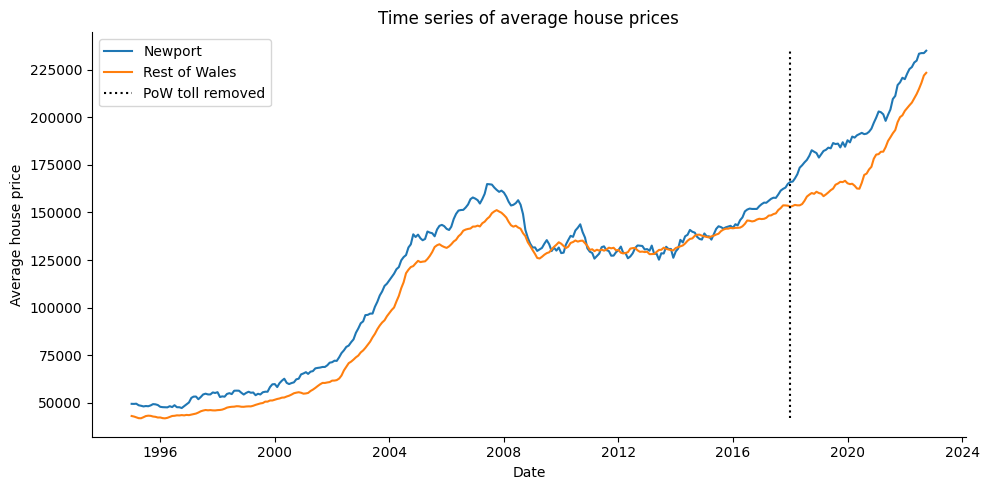

In [380]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.lineplot(data=data, x='Date', y='Average_Price', hue='Region_Name')
plt.vlines(treatment_date, ymin=min(data['Average_Price']), ymax=max(data['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel('Average house price')
plt.title('Time series of average house prices')
sns.despine()
plt.legend()
plt.tight_layout()
plt.savefig('output/newport_vs_avg.png')
plt.show()

In [381]:
all_wales_prices = prices[(prices['Area_Code'].str.startswith('W')) & (prices['Region_Name'] != 'Wales')][['Date', 'Region_Name', 'Average_Price']]

In [382]:
all_wales_prices_pvt = all_wales_prices[all_wales_prices['Date'].dt.date < treatment_date].pivot(index='Date', columns='Region_Name', values='Average_Price')

In [383]:
y = all_wales_prices_pvt['Newport'].values
X = all_wales_prices_pvt.drop(columns='Newport').values

## Extrapolation

In [384]:
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([ 0.181,  0.013,  0.222,  0.28 ,  0.194, -0.047,  0.136,  0.139,
        0.324, -0.31 , -0.219, -0.126,  0.055, -0.212,  0.031, -0.09 ,
        0.105,  0.089,  0.219, -0.333,  0.512])

In [385]:
wales_synth_lr = (all_wales_prices[all_wales_prices['Region_Name'] != 'Newport']
                  .pivot(index='Date', columns="Region_Name")["Average_Price"]
                  .values.dot(weights_lr))

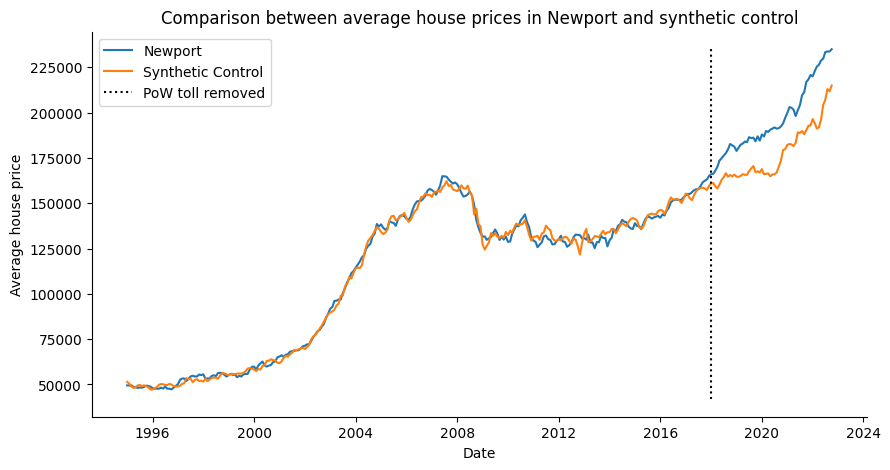

In [386]:
plt.figure(figsize=(10,5))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"], label="Newport")
plt.plot(all_wales_prices['Date'].unique(), wales_synth_lr, label="Synthetic Control")
plt.vlines(treatment_date, ymin=min(data['Average_Price']), ymax=max(data['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel("Average house price")
plt.xlabel("Date")
plt.title('Comparison between average house prices in Newport and synthetic control')
plt.legend()
sns.despine()
#plt.savefig('output/newport_vs_sc.png')
plt.show()


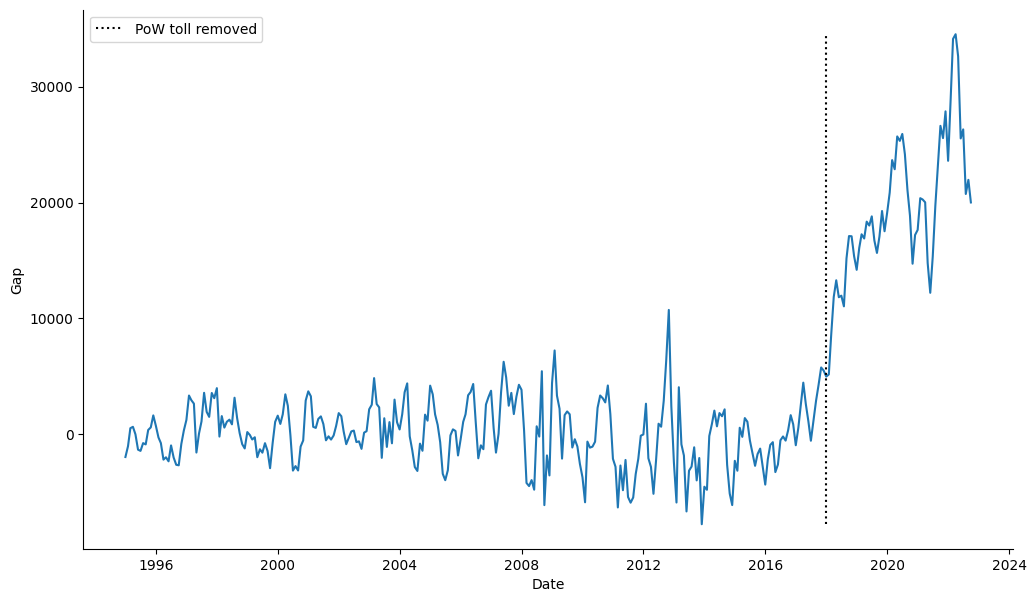

In [387]:

plt.figure(figsize=(12, 7))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr)
plt.vlines(treatment_date, 
           ymin=min(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr),
           ymax=max(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel('Gap')
plt.xlabel("Date")
plt.legend()
sns.despine()
#plt.savefig('output/gap.png')
plt.show()


In [388]:
def synthetic_control(region: str, data: pd.DataFrame) -> pd.DataFrame:
    
    inverted = data[data['Date'].dt.date < treatment_date].pivot(index='Date', columns='Region_Name', values='Average_Price')

    y = inverted[region].values
    X = inverted.drop(columns=region).values

    weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_

    synthetic = (all_wales_prices[all_wales_prices['Region_Name'] != region]
                .pivot(index='Date', columns="Region_Name")["Average_Price"]
                .values.dot(weights_lr))

    return data[data['Region_Name'] == region].assign(synthetic=synthetic)
    

In [389]:
list_la = all_wales_prices['Region_Name'].unique()

In [390]:
synthetic_las = [synthetic_control(x, all_wales_prices) for x in list_la] 

In [391]:
synthetic_las[0].tail()

,Date,Region_Name,Average_Price,synthetic
134039,2022-06-01,Powys,244481.06139,241619.009916
134414,2022-07-01,Powys,246066.40777,242510.448364
134810,2022-08-01,Powys,250364.17226,246474.016311
135301,2022-09-01,Powys,261591.01323,251020.566213
135651,2022-10-01,Powys,268531.48770,252566.968308


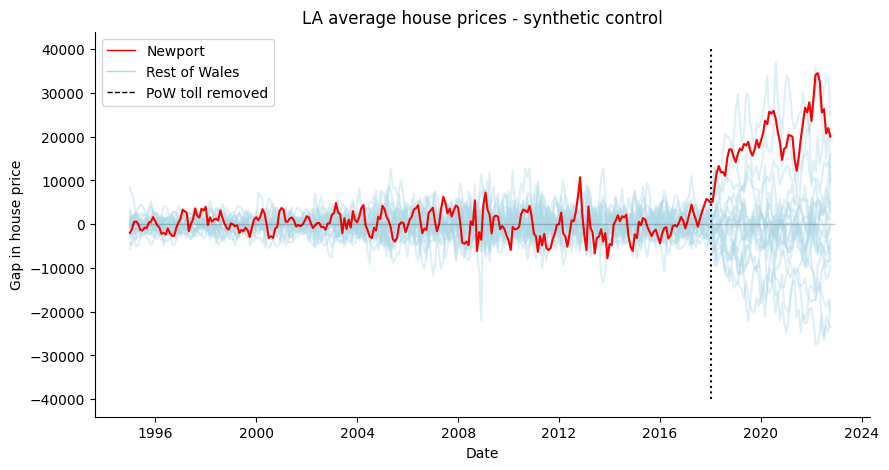

In [392]:
fig, ax = plt.subplots(figsize=(10, 5))

for la in synthetic_las:
    plt.plot(la['Date'], la['Average_Price'] - la['synthetic'], color='lightblue', alpha=0.4)

plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_lr, 
         color='red')
plt.vlines(treatment_date, ymin=-40000, ymax=40000, linestyles=':', colors='black', label='PoW toll removed')
plt.hlines(y=0, xmin=dt.date(1995, 1, 1), xmax=dt.date(2022, 12, 1), lw=1, alpha=0.2, color='black')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'PoW toll removed'])

plt.title('LA average house prices - synthetic control')
plt.ylabel('Gap in house price')
plt.xlabel('Date')
sns.despine()
#plt.savefig('output/gap_all.png')
plt.show()

In [393]:
effects = {la['Region_Name'].unique()[0]: np.mean(la[la['Date'].dt.date >= treatment_date]['Average_Price'] - la[la['Date'].dt.date >= treatment_date]['synthetic']) for la in synthetic_las}

effects_df = pd.DataFrame.from_dict(effects, orient='index').reset_index()
effects_df = effects_df.rename(columns={'index': 'la', 0: 'gap'}).sort_values('gap')


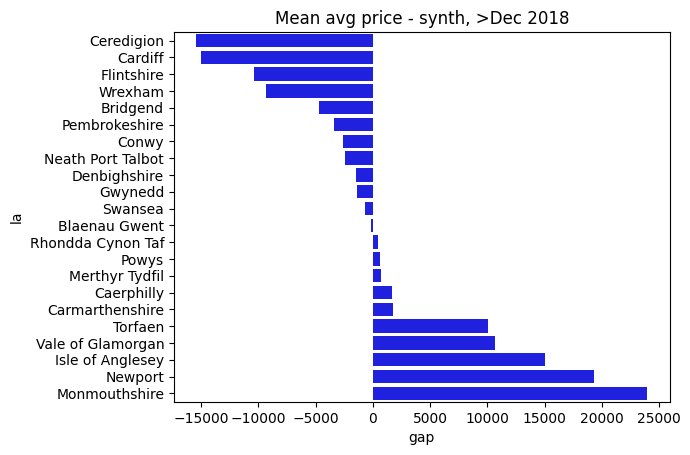

In [394]:
sns.barplot(data=effects_df, x='gap', y='la', orient='h', color='blue')
plt.title('Mean avg price - synth, >Dec 2018')
plt.show()

## Interpolation and outlier removal

In [395]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [396]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [397]:
weights_inter = get_w(X, y)
print("Sum:", weights_inter.sum())
np.round(weights_inter, 4)

Sum: 1.0000156195691838


array([0.    , 0.0586, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.206 , 0.    , 0.    , 0.    , 0.0284, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.7069])

In [398]:
wales_synth_inter = (all_wales_prices[all_wales_prices['Region_Name'] != 'Newport']
                    .pivot(index='Date', columns="Region_Name")["Average_Price"]
                    .values.dot(weights_inter))

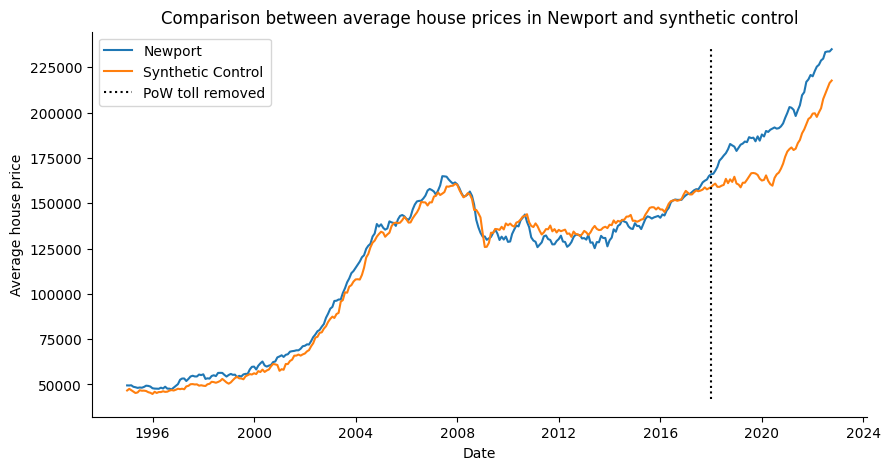

In [399]:
plt.figure(figsize=(10,5))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"], label="Newport")
plt.plot(all_wales_prices['Date'].unique(), wales_synth_inter, label="Synthetic Control")
plt.vlines(treatment_date, ymin=min(data['Average_Price']), ymax=max(data['Average_Price']),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel("Average house price")
plt.xlabel("Date")
plt.title('Comparison between average house prices in Newport and synthetic control')
plt.legend()
sns.despine()
plt.savefig('output/newport_vs_sc.png')
plt.show()

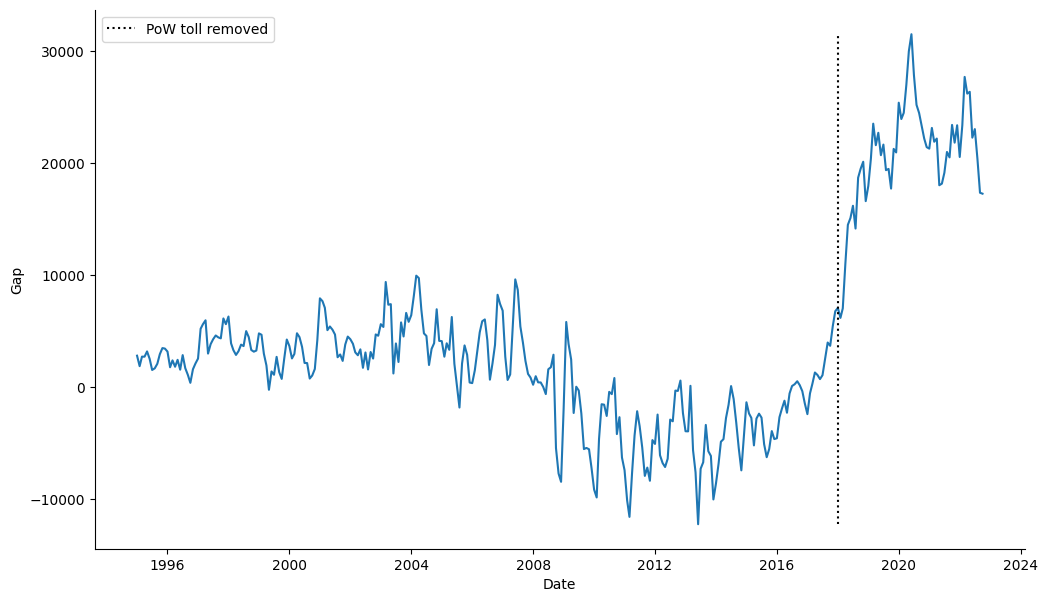

In [400]:

plt.figure(figsize=(12, 7))
plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter)
plt.vlines(treatment_date, 
           ymin=min(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter),
           ymax=max(all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter),
           linestyles=':', colors='black', label='PoW toll removed')
plt.ylabel('Gap')
plt.xlabel("Date")
plt.legend()
sns.despine()
plt.savefig('output/gap.png')
plt.show()


In [401]:
new = all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter
new.head()

364     2796.262241
750     1859.688576
1095    2711.011564
1431    2709.955421
1865    3179.421293
Name: Average_Price, dtype: float64

In [402]:
def synthetic_control_inter(region: str, data: pd.DataFrame) -> pd.DataFrame:
    
    inverted = data[data['Date'].dt.date < treatment_date].pivot(index='Date', columns='Region_Name', values='Average_Price')

    y = inverted[region].values
    X = inverted.drop(columns=region).values

    weights_inter = get_w(X, y)

    synthetic = (all_wales_prices[all_wales_prices['Region_Name'] != region]
                .pivot(index='Date', columns="Region_Name")["Average_Price"]
                .values.dot(weights_inter))
                
    return data[data['Region_Name'] == region].assign(synthetic=synthetic).reset_index()
    

In [403]:
synthetic_las_inter = [synthetic_control_inter(x, all_wales_prices) for x in list_la] 

In [404]:
synthetic_las_inter[0]

,index,Date,Region_Name,Average_Price,synthetic
0,295,1995-01-01,Powys,44711.43239,50843.977953
1,681,1995-02-01,Powys,46037.67155,50705.457614
2,1114,1995-03-01,Powys,47201.99502,49814.855878
3,1489,1995-04-01,Powys,46783.20605,48847.312664
4,1871,1995-05-01,Powys,48339.67538,48279.742603
...,...,...,...,...,...
329,134039,2022-06-01,Powys,244481.06139,251300.378798
330,134414,2022-07-01,Powys,246066.40777,253718.251959
331,134810,2022-08-01,Powys,250364.17226,257930.526663
332,135301,2022-09-01,Powys,261591.01323,261599.820962


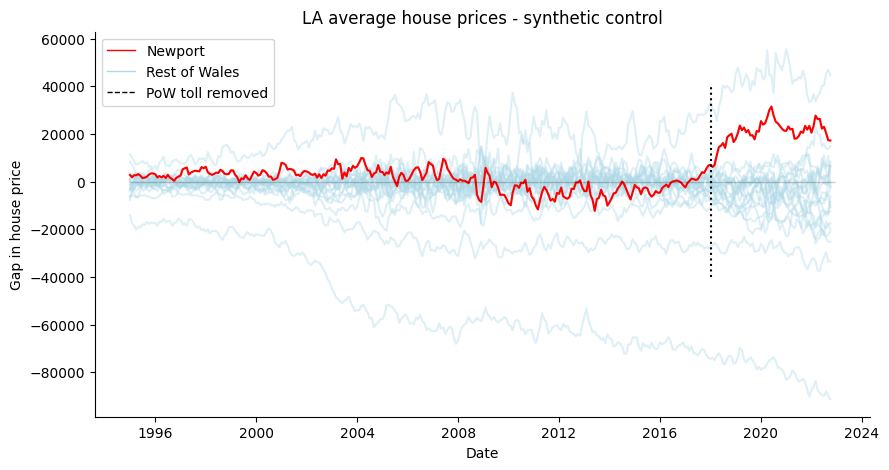

In [405]:
fig, ax = plt.subplots(figsize=(10, 5))

for la in synthetic_las_inter:
    plt.plot(la['Date'], la['Average_Price'] - la['synthetic'], color='lightblue', alpha=0.4)

plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter, 
         color='red')
plt.vlines(treatment_date, ymin=-40000, ymax=40000, linestyles=':', colors='black', label='PoW toll removed')
plt.hlines(y=0, xmin=dt.date(1995, 1, 1), xmax=dt.date(2022, 12, 1), lw=1, alpha=0.2, color='black')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'PoW toll removed'])

plt.title('LA average house prices - synthetic control')
plt.ylabel('Gap in house price')
plt.xlabel('Date')
sns.despine()
plt.show()

In [406]:
# remove outliers

def pre_treatment_error(la):
    pre_treat_error = np.sqrt((la[la['Date'].dt.date < treatment_date]['Average_Price'] 
                       - la[la['Date'].dt.date < treatment_date]["synthetic"]) ** 2)
    return pre_treat_error.mean()


In [407]:
def post_treatment_effect(la):
    pre_treat_error = (la[la['Date'].dt.date >= treatment_date]['Average_Price'] 
                       - la[la['Date'].dt.date >= treatment_date]["synthetic"])
    return pre_treat_error.mean()


Bridgend : 8638.39101175638
Caerphilly : 19505.250583419598
Monmouthshire : 18774.603783788283
Blaenau Gwent : 48128.42755258453


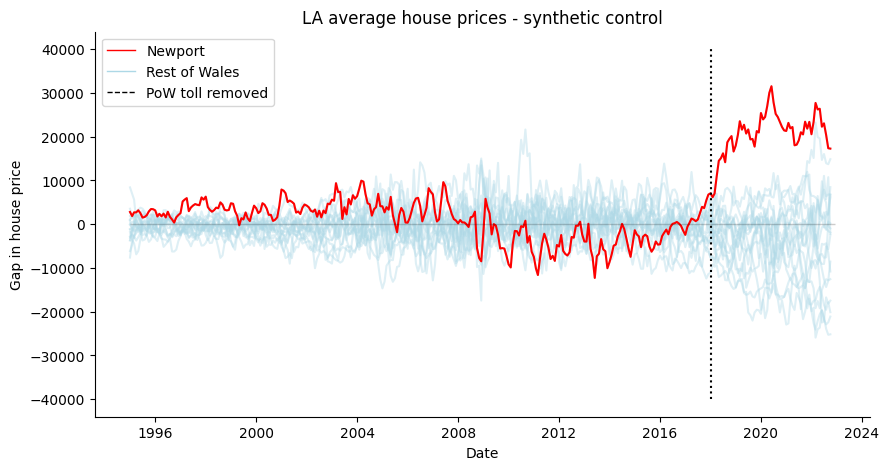

In [408]:
effects = {}

fig, ax = plt.subplots(figsize=(10, 5))

for la in synthetic_las_inter:
    if pre_treatment_error(la) < 5000:
        plt.plot(la['Date'], la['Average_Price'] - la['synthetic'], color='lightblue', alpha=0.4)
        effects[la['Region_Name'].unique()[0]] = post_treatment_effect(la)
    else:
        print(la['Region_Name'].unique()[0], ':', pre_treatment_error(la))

plt.plot(all_wales_prices['Date'].unique(), all_wales_prices[all_wales_prices['Region_Name'] == 'Newport']["Average_Price"] - wales_synth_inter, 
         color='red')
plt.vlines(treatment_date, ymin=-40000, ymax=40000, linestyles=':', colors='black', label='PoW toll removed')
plt.hlines(y=0, xmin=dt.date(1995, 1, 1), xmax=dt.date(2022, 12, 1), lw=1, alpha=0.2, color='black')

legend_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='lightblue', lw=1),
                Line2D([0], [0], color='black', linestyle='dashed', lw=1)]

ax.legend(legend_lines, ['Newport', 'Rest of Wales', 'PoW toll removed'])

plt.title('LA average house prices - synthetic control')
plt.ylabel('Gap in house price')
plt.xlabel('Date')
sns.despine()
plt.savefig('output/gap_all.png')
plt.show()

In [409]:
effects_df_inter = pd.DataFrame.from_dict(effects, orient='index').reset_index()

In [410]:
effects_df_inter = effects_df_inter.rename(columns={'index': 'la', 0: 'effect'})
effects_df_inter.sort_values(by='effect', inplace=True)

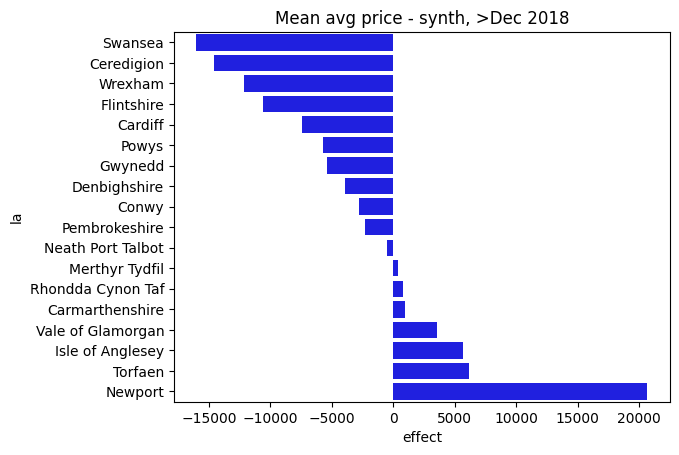

In [411]:
sns.barplot(data=effects_df_inter, x='effect', y='la', orient='h', color='blue')
plt.title('Mean avg price - synth, >Dec 2018')
plt.show()